# Solving the n-Queens Problem using Local Search

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]


## Learning Outcomes

* Implement multiple hill climbing search variants to solve the n-Queens problem.
* Apply simulated annealing with appropriate temperature scheduling to overcome local optima.
* Compare algorithm performance using runtime, solution quality, and success rate metrics.
* Analyze and visualize algorithm performance across different problem sizes.
* Graduate Students: Design and test alternative local move operators to improve search efficiency.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file. 

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


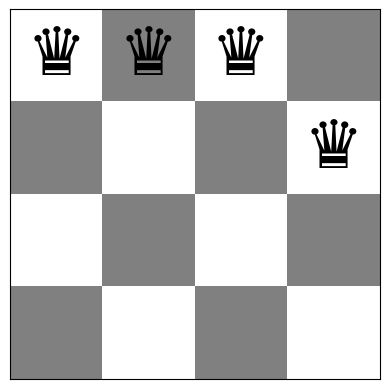

Queens (left to right) are at rows: [0 0 0 1]
Number of conflicts: 4


In [69]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


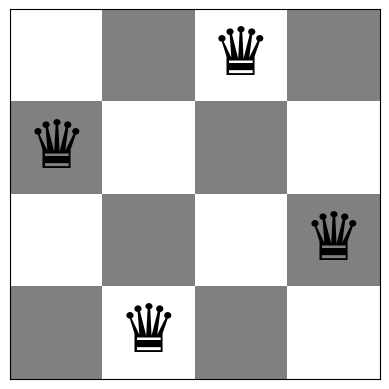

In [57]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [20 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

In [ ]:
def steepest_ascent_hill_climb(board):
    n = len(board)
    cur_board = board.copy()
    cur_conflict = conflicts(cur_board)

    while True:
        best_conflict = cur_conflict
        best_board = cur_board.copy()

        for col in range(n):
            for row in range(n):
                if row != cur_board[col]:
                    new_board = cur_board.copy()
                    new_board[col] = row
                    new_conflict = conflicts(new_board)

                    # Nếu nước đi này tốt hơn thì lưu lại
                    if new_conflict < best_conflict:
                        best_conflict = new_conflict
                        best_board = new_board.copy()

        # Nếu không có cải thiện nào thì dừng
        if best_conflict >= cur_conflict:
            return cur_board, cur_conflict
        
        # Ngược lại, cập nhật bàn cờ và tiếp tục leo dốc
        cur_board = best_board.copy()
        cur_conflict = best_conflict


Initial board: [1, 3, 0, 2]
Final board: [1, 3, 0, 2]
Board with 0 conflicts.


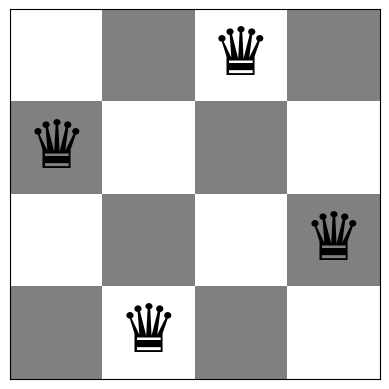

Conflicts: 0


In [60]:
result, conf = steepest_ascent_hill_climb(board)
print("Initial board:", board)
print("Final board:", result)
show_board(result)
print("Conflicts:", conf)

## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [61]:
def stochastic_hill_climb_1(board, max_iter=10000):
    n = len(board)
    cur_board = board.copy()
    cur_conflict = conflicts(cur_board)

    for step in range(max_iter):
        # Chọn ngẫu nhiên 1 cột và 1 hàng khác vị trí hiện tại
        col = np.random.randint(0, n)
        row = np.random.randint(0, n)
        while row == cur_board[col]:
            row = np.random.randint(0, n)

        # Tạo bàn cờ mới
        new_board = cur_board.copy()
        new_board[col] = row
        new_conflict = conflicts(new_board)

        # Nếu nước đi này tốt hơn thì chấp nhận
        if new_conflict < cur_conflict:
            cur_board = new_board
            cur_conflict = new_conflict

        # Nếu đã đạt nghiệm tối ưu thì dừng
        if cur_conflict == 0:
            break

    return cur_board, cur_conflict

Initial board: [3, 3, 3, 3]
Final board: [0, 3, 1, 2]
Board with 1 conflicts.


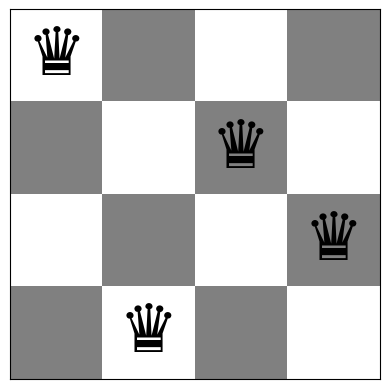

Conflicts: 1


In [38]:
result, conf = stochastic_hill_climb_1(board)
print("Initial board:", board)
print("Final board:", result)
show_board(result)
print("Conflicts:", conf)

## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [62]:
def stochastic_hill_climb_2(board, max_iter=10000):
    n = len(board)
    cur_board = board.copy()
    cur_conflict = conflicts(cur_board)

    for step in range(max_iter):
        # Chọn ngẫu nhiên 1 quân hậu và 1 hàng mới
        col = np.random.randint(0, n)
        row = np.random.randint(0, n)
        if row == cur_board[col]:
            continue  # bỏ qua nếu không thay đổi vị trí
        
        # Tạo hàng xóm
        new_board = cur_board.copy()
        new_board[col] = row
        new_conflict = conflicts(new_board)

        # Nếu tốt hơn thì chấp nhận
        if new_conflict < cur_conflict:
            cur_board = new_board
            cur_conflict = new_conflict

        # Nếu đạt nghiệm hoàn hảo thì dừng
        if cur_conflict == 0:
            break
    
    return cur_board, cur_conflict

Initial board: [3, 3, 3, 3]
Final board: [2, 0, 3, 1]
Board with 0 conflicts.


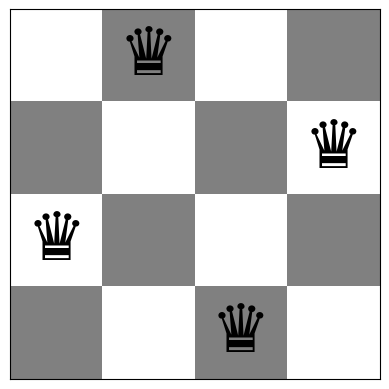

Conflicts: 0


In [45]:
result, conf = stochastic_hill_climb_2(board)
print("Initial board:", board)
print("Final board:", result)
show_board(result)
print("Conflicts:", conf)

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

In [73]:
def hill_climb_random_restarts(n, max_restarts=100, max_iter=10000):

    best_board = None
    best_conflict = float('inf')  # khởi tạo vô cực để tìm min

    for restart in range(max_restarts):
        # Bắt đầu với 1 bàn cờ ngẫu nhiên
        board = random_board(n)
        cur_board = board.copy()
        cur_conflict = conflicts(cur_board)

        # --- Stochastic Hill Climbing ---
        for step in range(max_iter):
            col = np.random.randint(0, n)
            row = np.random.randint(0, n)
            if row == cur_board[col]:
                continue

            new_board = cur_board.copy()
            new_board[col] = row
            new_conflict = conflicts(new_board)

            if new_conflict < cur_conflict:
                cur_board = new_board
                cur_conflict = new_conflict

            if cur_conflict == 0:
                break  # đạt nghiệm tối ưu

        # Cập nhật bàn tốt nhất
        if cur_conflict < best_conflict:
            best_conflict = cur_conflict
            best_board = cur_board

        # Nếu tìm được lời giải hoàn hảo, dừng ngay
        if best_conflict == 0:
            break

    return best_board, best_conflict

Initial board: [0 0 0 1]
Final board: [2 0 3 1]
Board with 0 conflicts.


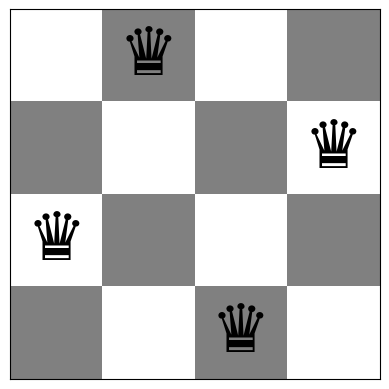

Conflicts: 0


In [74]:
result, conf = hill_climb_random_restarts(len(board))
print("Initial board:", board)
print("Final board:", result)
show_board(result)
print("Conflicts:", conf)

## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Create a visualization of the search process (a line chart of how the number if conflict changes as the algorithm progrsses).
3. Use this visualization for experiments with different choices for the annealing schedule and discuss what you have learned.

In [76]:
def simulated_annealing(board, max_iter=10000, T0=10.0, alpha=0.995):

    board = board.copy()
    n = len(board)
    cur_conflict = conflicts(board)
    T = T0
    conflict_history = [cur_conflict]

    for step in range(max_iter):
        if cur_conflict == 0:
            break

        # Chọn ngẫu nhiên một quân hậu và một hàng mới
        col = np.random.randint(0, n)
        row = np.random.randint(0, n)
        if row == board[col]:
            continue

        new_board = board.copy()
        new_board[col] = row
        new_conflict = conflicts(new_board)

        delta = new_conflict - cur_conflict

        # Chấp nhận nếu tốt hơn hoặc theo xác suất P
        if delta <= 0 or np.random.rand() < np.exp(-delta / T):
            board = new_board
            cur_conflict = new_conflict

        conflict_history.append(cur_conflict)
        T *= alpha  # giảm nhiệt độ

    return board, cur_conflict

Initial board: [0 0 0 1]
Final board: [1 3 0 2]
Board with 0 conflicts.


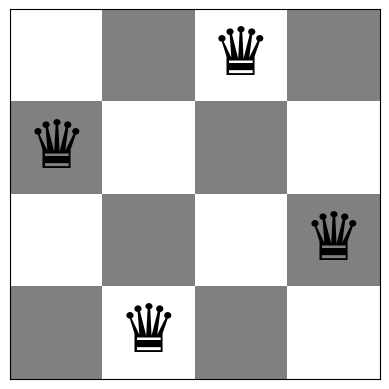

Conflicts: 0


In [77]:
result, conf = simulated_annealing(board)
print("Initial board:", board)
print("Final board:", result)
show_board(result)
print("Conflicts:", conf)

## Task 6: Algorithm Behavior Analysis [20 Points]

### Comparison
Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                   |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                   |   |

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

Add the used code here:

In [78]:
import time
import pandas as pd

In [81]:
def compare_algorithms(board_sizes=[4,8], runs=10):
    algorithms = {
        "Steepest asc. HC": steepest_ascent_hill_climb,
        "Stochastic HC 1": stochastic_hill_climb_1,
        "Stochastic HC 2": stochastic_hill_climb_2,
        "Simulated Annealing": simulated_annealing
    }

    results = []

    for n in board_sizes:
        for name, algo in algorithms.items():
            conflicts_list = []
            run_times = []
            optimal_count = 0

            for r in range(runs):
                board = random_board(n)
                start = time.time()
                final_board, final_conflict = algo(board)
                end = time.time()

                conflicts_list.append(final_conflict)
                run_times.append(end - start)
                if final_conflict == 0:
                    optimal_count += 1

            results.append({
                "Algorithm": name,
                "Board size": n,
                "Avg. Run time": round(np.mean(run_times),5),
                "Avg. number of conflicts": round(np.mean(conflicts_list),2),
                "% of runs ending in optimal solution": round(100*optimal_count/runs,2)
            })

    df = pd.DataFrame(results)
    return df

In [83]:
from tabulate import tabulate
print(tabulate(compare_algorithms(), headers='keys', tablefmt='grid'))


+----+---------------------+--------------+-----------------+----------------------------+----------------------------------------+
|    | Algorithm           |   Board size |   Avg. Run time |   Avg. number of conflicts |   % of runs ending in optimal solution |
+====+=====================+==============+=================+============================+========================================+
|  0 | Steepest asc. HC    |            4 |         0.00075 |                        0.9 |                                     10 |
+----+---------------------+--------------+-----------------+----------------------------+----------------------------------------+
|  1 | Stochastic HC 1     |            4 |         0.1627  |                        0.6 |                                     50 |
+----+---------------------+--------------+-----------------+----------------------------+----------------------------------------+
|  2 | Stochastic HC 2     |            4 |         0.1913  |               

### Algorithm Convergence

For each algorithm implemented, describe the typical convergence pattern (fast initial improvement vs. steady progress).
Include a plot showing the objective function value over iterations for one representative run of each algorithm on the 8-queens problem.
Explain which algorithms exhibit plateaus or getting stuck in local optima most frequently.

In [ ]:
# Code and description go here

### Problem Size Scalability

Create a log-log plot showing how runtime scales with board size ($n=4, 8, 12, 16, 20$) for at least two algorithms.
Estimate the empirical time complexity (Big O) for each algorithm based on your results.
Identify which algorithm scales best for large problem sizes and explain why.

In [ ]:
# Code and description go here

## Advanced task: Exploring other Local Moves Operators

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### Move Operator Implementation 

Implement the following local move operators:

* Single-step move: Move one queen only one square up or down at a time
* Column swap: Exchange the positions of queens in two randomly selected columns
* Dual-queen move: Select two queens and move both simultaneously
* Adaptive move: Design your own operator that adapts which local move it uses based on the current state (e.g., focuses on queens with most conflicts or randomly chooses one of the moves above)

### Experimental Analysis

Using the 8-Queens and 12-Queens problems: Run your Stochastic Hill Climbing 2 implementation with each move operator 100 times
For each operator, create a visualization showing:

* Average solution quality over iterations
* Distribution of final solution qualities
* Average time to solution for successful runs

### Discussion

Describe what you have learned from the experiments. Which operator works best for which situation and why?

In [9]:
# Code and description go here

## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Implement a Genetic Algorithm for the n-Queens problem

In [10]:
# Code and description go here